# Trabajo Práctico n° 2
## Primera parte: Espacio de color YIQ

En esta primera parte, se buscar implementar dos funciones de conversión que permitan trasformar el espacio de color original de una imagen (RGB), al espacio de color YIQ y viceversa.

Posteriormente, utilizando la proyección en el espacio YIQ de la imagen, se altera su luminancia (eje Y) y cromaticidad (el plano conformado por los ejes I y Q), verificando sus efectos devolviéndola a su espacio de color original. Teóricamente, la alteración de la luminancia debería sólo cambiar la "brillantez" u "oscuridad" de los colores, sin alterar estos mismos.
Por otro lado, una alteración en la cromaticidad producirá un cambio en la saturación de esos colores, desde más "puros" a más "grises".

In [2]:
#Mounting 
from google.colab import drive 

drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

drive_dir = '/content/gdrive/My Drive/Doctorado/PDI/images/' #Directory

#UPLOADING IMAGE AS A NUMPY IMAGE
img = imageio.imread(drive_dir + 'lemur.jpg')
print("Image: ")
plt.imshow(img)
plt.show()

FileNotFoundError: ignored

Retomando la imagen del trabajo anterior, definimos las funciones de conversión, las cuales son básicamente transformaciones lineales de los vectores de color. Hay dos cuestiones a tener en cuenta: una es que requerimos que el vector de color RGB debe estar normalizado para realizar proyecciones; una segunda cuestión son los intervalos de validez de cada eje. 

Como sabemos, las tres variables de color del espacio RGB tienen definido su intervalo de validez como [0, 255]. De forma similar, las variables conformantes del espacio YIQ tienen sus propios intervalos de validez:

*  $ Y \in [0, 1] $
*  $ I \in [-0.5957, 0.5957]$
*  $ Q \in [-0.5226, 0.5226]$

Por lo tanto, al final de la conversión "en crudo", se aplica la función *clip* de NumPy, para truncar los valores por fuera del intervalo de validez.



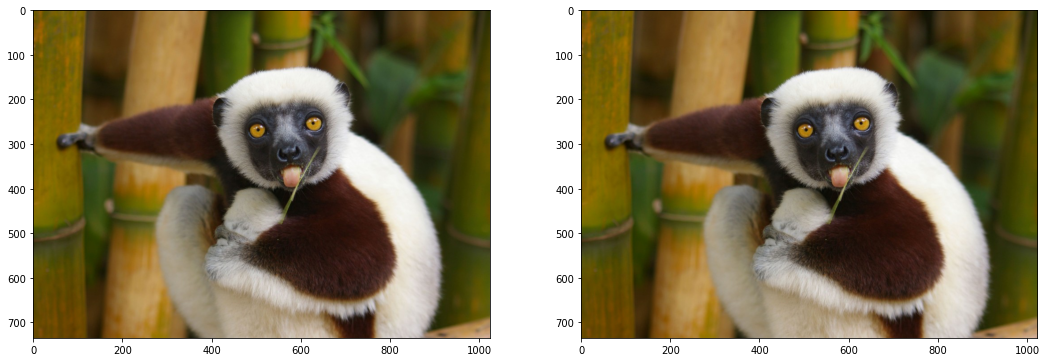

In [6]:
def RGBtoYIQ(img_rgb):
  coef = np.array([[   0.299,     0.587,     0.114],
                   [0.595716, -0.274453, -0.321263],
                   [0.211456, -0.522591,  0.311135]])
  
  img_norm = img_rgb / 255 #Normalization of RGB vector
  dims = img_rgb.shape
  img_yiq = np.zeros(dims)
  for i in range(dims[0]):
    for j in range(dims[1]):
      img_yiq[i, j, :] = np.matmul(coef, img_norm[i, j, :])
  np.clip(img_yiq[:,:,0],       0,      1, out=img_yiq[:,:,0])  #       0 <= Y <= 1
  np.clip(img_yiq[:,:,1], -0.5957, 0.5957, out=img_yiq[:,:,1])  # -0.5957 <= I <= 0.5957
  np.clip(img_yiq[:,:,2], -0.5226, 0.5226, out=img_yiq[:,:,2])  # -0.5226 <= Q <= 0.5226
  return img_yiq

def YIQtoRGB(img_yiq):
  coef = np.array([[1,  0.9663,  0.6210],
                   [1, -0.2721, -0.6474],
                   [1, -1.1070,  1.7046]])
  
  dims = img_yiq.shape
  img_norm_rgb = np.zeros(dims)
  for i in range(dims[0]):
    for j in range(dims[1]):
      img_norm_rgb[i, j, :] = np.matmul(coef, img_yiq[i, j, :])
  np.clip(img_norm_rgb, 0, 1, out=img_norm_rgb)
  return np.uint8(np.floor(img_norm_rgb * 255)) #De-normalization of normalized RGB vector

new_img = YIQtoRGB(RGBtoYIQ(img))

#PLOTTING
fig, axs = plt.subplots(1, 2, figsize=(img.shape[0]//40, img.shape[1]//40))
axs[0].imshow(img)
axs[1].imshow(new_img)
plt.show()


Podemos corroborar que los métodos fueron bien implementados al visualizar una imagen que fue proyectada al espacio YIQ y reproyectada al espacio RGB. 

Sin embargo, como en el proceso de proyección hay una instancia de truncamiento de los valores que hayan podido quedar fuera del espacio de color concebido, es esperable que no se haya conservado la información original de la imagen en su completitud. Para visualizar esta situación, podemos comparar los histogramas de ambas imágenes, la original y las reproyectada.

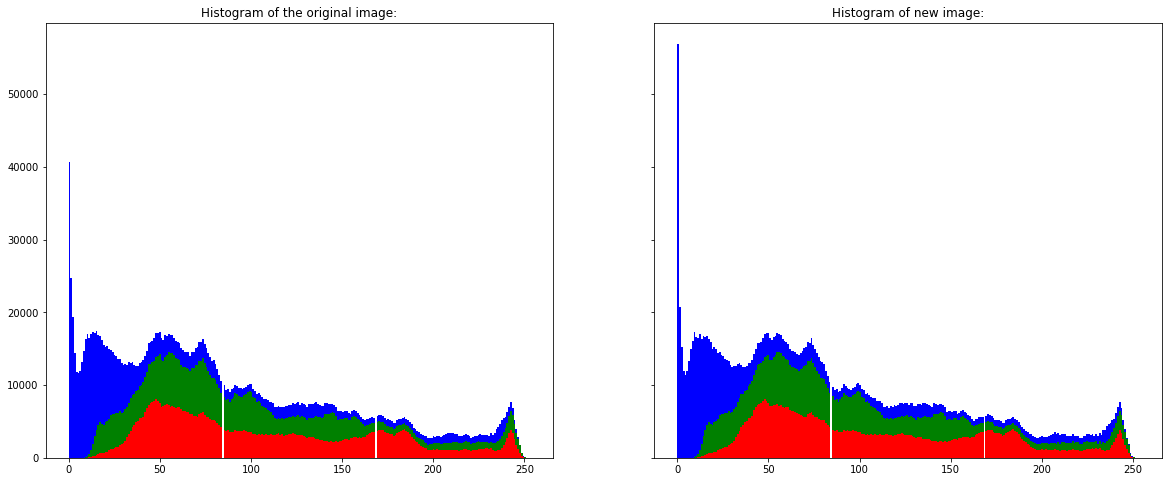

In [ ]:
#PLOTTING
fig_hist, axs = plt.subplots(1, 2,sharey=True, figsize=(20, 8))
axs[0].hist(img.reshape(-1, 3), bins=256, color=['red', 'green', 'blue'], histtype='bar', stacked=True)
axs[0].set_title('Histogram of the original image:')
axs[1].hist(new_img.reshape(-1, 3), bins=256, color=['red', 'green', 'blue'], histtype='bar', stacked=True)
axs[1].set_title('Histogram of new image:')
plt.show()

En un primer vistazo, el histograma nuevo parece conservar casi en su totalidad la información de la imagen original. No obstante, podemos visualizar fácilmente un aumento en la frecuencia de los valores más bajos en el canal azul. Esto significa que algunos vectores de color perdieron su valor de azul original al caer fuera del espacio de color durante la proyección, distorcionando su información al ser reproyectados.


Por último, para esta primera instancia, definimos dos coeficientes variables para regular la luminancia y cromaticidad de la imagen.

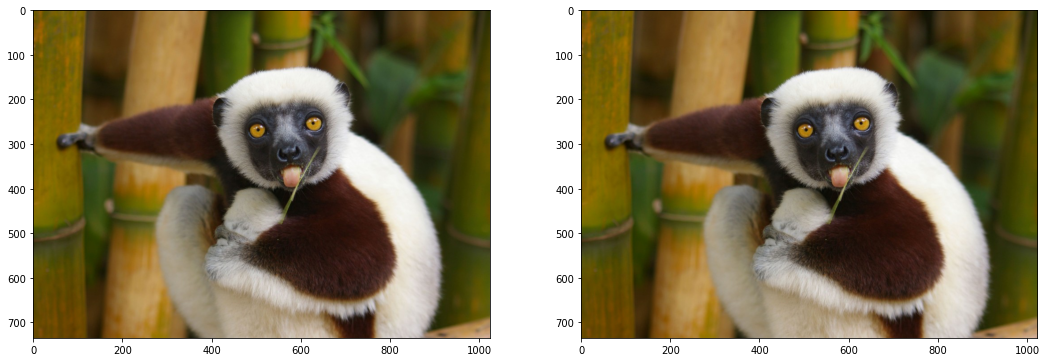

In [ ]:
#@title Luminance and Chromaticity Modification {run:"auto"}
def alter_image(img, Y_coef, IQ_coef):
  yiq_img = RGBtoYIQ(img)
  yiq_img[:, :, 0] *= Y_coef
  yiq_img[:, :, 1:] *= IQ_coef
  return YIQtoRGB(yiq_img)

Luminance = 1 #@param {type:"slider", min:0, max:1, step:0.01}
Chromaticity = 1 #@param {type:"slider", min:0, max:1, step:0.01}

#PLOTTING
fig, axs = plt.subplots(1, 2, figsize=(img.shape[0]//40, img.shape[1]//40))
axs[0].imshow(img)
axs[1].imshow(alter_image(img, Luminance, Chromaticity))
plt.show()

## Segunda parte: Mapas cromáticos

En esta segunda parte, trabajamos con datasets bidimensionales, los cuales debemos utilizar una paleta de color para poder visualizarlos en una imagen.

El dataset a utilizar es una imagen en formato .tif, el cual se una imagen en la que cada celda (x, y) se le asigna un valor real que representa la altura de una región en el espacio. Este formato es muy utilizado en el estudio geoespacial. 

Luego, definimos una función que configura un contexto del dataset que queremos mapear, y un tipo de paleta. Definimos 4 paletas que explicaremos a continuación.

In [43]:
#CHROMATIC MAPPING AND SELECTOR
def set_palette(img):
  dims = (img.shape[0], img.shape[1], 3)
  img_min = np.min(img)
  img_max = np.max(img)
  I_amp = 0.5957 #I max amplitude
  Q_amp = 0.5226 #Q max amplitude

  def chrom_mapping(type):
    yiq_img = np.zeros(dims)
    if type == 'gray':                                        #GRAY MAPPING
      for i in range(dims[0]):
        for j in range(dims[1]):
          #Just mananging luminance [0, 1]
          yiq_img[i, j, 0] = (img[i, j] - img_min) / (img_max - img_min)
      
    elif type == 'rainbow':                                   #RAINBOW MAPPING
      w = 3 * np.pi / 2
      for i in range(dims[0]):
        for j in range(dims[1]):
          #Walking along the ellipse on the IQ-plane,
          #starting at a quarter of cirunference (approx purple),
          #counterclockwise to cero of the circunference (approx red)
          t = 1 - (img[i, j] - img_min) / (img_max - img_min)
          yiq_img[i, j, 0] = 1 - t #Adding luminance
          yiq_img[i, j, 1] =   I_amp * np.cos(w * t)
          yiq_img[i, j, 2] = - Q_amp * np.sin(w * t)
      
    elif type == 'saturation':                              #SATURATION MAPPING
      yiq_img[:, :, 0] = 0.5 #fixed luminance
      for i in range(dims[0]):
        for j in range(dims[1]):
          #Managing IQ-plane
          t = (img[i, j] - img_min) / (img_max - img_min)
          yiq_img[i, j, 1] = I_amp * t
          yiq_img[i, j, 2] = Q_amp * t
    
    elif type == 'luminance':
      #fixed chromaticity
      yiq_img[:, :, 1] = I_amp
      yiq_img[:, :, 2] = Q_amp
      for i in range(dims[0]):
        for j in range(dims[1]):
          #Managing Luminance
          yiq_img[i, j, 0] = (img[i, j] - img_min) / (img_max - img_min)
      
    #RETURNING MAPPED IMAGE
    return YIQtoRGB(yiq_img)
  
  return chrom_mapping

Las paletas mapean el intervalo *[mínimo de altura, máximo de altura]* a un nuevo intervalo que corresponde a la luminancia, cromaticidad o una combinación de ambas, según corresponda el tipo de paleta. A continuación, explicamos cómo se implementaron:

* **Paleta de grises:** en esta paleta la cromaticidad es nula (es decir, tanto I como Q son nulas). La única variable es la luminancia. Por tanto, la asignación del intervalo de alturas se directo sobre el intervalo de validez de la luminancia (*[0, 1]*).
* **Paleta de arcoiris:** aprovechando la distribución polar de los colores en el plano IQ, aquí la asignación se hace mediante el recorrido de una semielipse, cuyos radios mayor y menor son el valor máximo posible en cada eje (para I, $I_max = 0.5957$ y para $Q_max = 0.5226$). En realidad, la curva real a recorrer es el rectángulo conformado por las fronteras del plano IQ, pero por simplicidad en la regla de proyección, se decidió por la elipse, que permite mayor control. La asignación se realiza en el intervalo $[\frac{\pi}{2}, 2\pi]$, donde el extremo izquierdo es aproximadamente un morado, mientras el extremo derecho es aproximadamente un rojo. Además, al no completar la elipse, se evita que se pisen los valores extremos al mapearse. Para generar mayor contraste, se incorpora una variación en la luminancia, asignando así el valor $Y= 0$ para el morado (el morado más oscuro) y el valor $Y=1$ para el rojo (el rojo más brillante). En conjunto, la regla de asignación es una helicoide con el eje en la luminancia y el recorrido semielíptico paralelo al plano IQ, en sentido antihorario.
* **Paleta por saturación:** en este casi, se fija la luminancia arbitraria, y se "traza" una recta en el plano IQ, la cual representa un único color (es decir, el cociente entre I y Q es constante). El recorrido de esa recta produce una variación en la saturación de dicho color, la cual pinta el mapa deseado.
* **Paleta por luminancia:** por último, construimos una paleta en la que nuevamente la luminancia marca las distinciones. Pero a diferencia de la paleta de grises, en este caso la cromaticidad está fija en valores no nulos (por simplicidad, se eligió el valor máximo en cada eje).


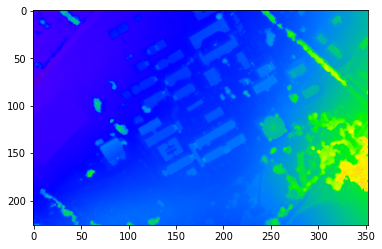

In [50]:
#@title Choose a palette { run: "auto" }
#CHROMATIC MAPPING
palette_type = 'rainbow' #@param ['gray','rainbow', 'saturation', 'luminance']
terrain = imageio.imread(drive_dir + 'CampusUniversitario.tif')

#Chromatic spaces for visualization
chrom_mapping = set_palette(terrain)
mapped_terrain = chrom_mapping(palette_type)
plt.imshow(mapped_terrain)

Podemos notar rápidamente, que tanto la paleta de grises como paleta por luminancia representan de manera notoria la información del dataset. Es decir, todas o casi todas las alturas son fácilmente reconocibles.
Por otro lado, la paleta de arcoiris se comporta bien en general, salvo para los valores más bajos. Allí, resulta más difícil distinguir las alturas, ya que los colores tienden a fundirse.
Por último la paleta por saturación directamente no nos ayuda a la visualización de los datos, ya que las alturas no son lo suficientemente bruscas o suaves para generar grandes contrastes.